# Python code to reproduce the plots of section 4.3 of the paper entiltled "On the profitability of selfish blockchain mining under consideration of ruin "

In [1]:
%config InlineBackend.figure_format = 'retina'
%run -i ./revenue_protocol.py
%run -i ./revenue_selfish.py
%run -i ./revenue_selfish_eyal_sirer.py

# Importation of the time series
π_BTC_data = pd.read_csv("BTC_USD_2013-10-01_2020-05-23-CoinDesk.csv")
tW_data = pd.read_csv("elec_consumption_BTC_CBECI.csv")

# Date reformating
π_BTC_data['Date2'] = pd.to_datetime(π_BTC_data['Date'])
tW_data['Date'] = pd.to_datetime(tW_data['Date and Time'])
π_BTC_df = π_BTC_data[['Date2','Closing Price (USD)']].rename(columns={"Date2": "Date", "Closing Price (USD)": "π_BTC"})
tW_df = tW_data[['Date','GUESS']].rename(columns={"GUESS": "tW"})
# Date considered
Date = '2020-01-01'
# Operational cost of the network
W =  tW_df.tW[tW_df.Date == Date].values[0] * 10**9 / 365.25 / 24
print('On January 1, 2020')
print('The network consumes ' + str(tW_df.tW[tW_df.Date == Date].values[0]) + ' tW per year')  
print('The network consumes ' + str(W) + ' kW per hour')  
# Block reward
n_BTC, π_BTC = 12.5, π_BTC_df.π_BTC[π_BTC_df.Date == '2020-01-01'].values[0]
b = n_BTC * π_BTC
print('The BTC price is $' + str(π_BTC) )
print('The reward for finding a block amount to $' + str(b) )

# Intensity of the Poisson process
λ = 6
print('The time unit is the hour so λ = ' + str(λ))

# Plot parameters
fontsize_axes = 18.0
fontsize_ticker = 16.0
rg = Generator(PCG64(123))


On January 1, 2020
The network consumes 72.1671 tW per year
The network consumes 8232614.647501711 kW per hour
The BTC price is $7174.7440119511
The reward for finding a block amount to $89684.30014938876
The time unit is the hour so λ = 6


The goal of the supplementary material is to compare the ruin probabilities and expected surplus of miners implementing Eyal and Sirer selfish mining strategy and the simplified version we study in the paper "On the profitability of selfish blockchain mining under the consideration of ruin". Note that we modified the initial strategy to uphold the Marvian nature of the risk process which allowed us in turn to derive closed form expressions for the quantities. 

In [2]:
λ, t, p, q =6, 12, 0.01 , 0.5
denom = 1+2*p-p**2
p_U = [(1+p*(1-p)+p*(1-p)**2*(1-q))/denom, (p*q*(1-p)**2)/denom, (p**2+p**2*(1-p))/denom]
  
print('The net benefit condition holds if the price is smaller than '
      + str(np.around(λ * b / W, decimals = 3))+
      ' when following the protocol')
print('The net benefit condition holds if the price is smaller than '
      + str(np.around(b*λ*(p_U[1]+2*p_U[2]) / W / p , decimals = 3))+
      ' when mining selfishly')

The net benefit condition holds if the price is smaller than 0.065 when following the protocol
The net benefit condition holds if the price is smaller than 0.034 when mining selfishly


In [3]:
V_AG_df = pd.read_csv("../Maple/V_selfish_data_ES.csv", header = 0)
rp_AG_df = pd.read_csv("../Maple/rp_selfish_data_ES.csv", header = 0).rename(columns = {'&Psi;_T': 'ψ_T'})


Code to generate the data to check that our results are consistent with MC simulations 

In [4]:
π_W = 0.03
u_vec = np.arange(10000, 1000000, 50000) # Sequence of initial reserves
rg, K = Generator(PCG64(123)), 100000 #Number of sample path
Z_0 = 0
ψ_V_MC_df = pd.DataFrame()
p_seq = [0.01, 0.1, 0.25, 0.4]
t_seq = [24*14]
for t in t_seq:
    for p in p_seq:
        c = p * π_W * W 
        sim_data = sim_data_self_T_ES(t, λ, p, q, Z_0, K, rg)
        res_T = [V_T_self_MC_ES(u, t, λ, p, q, b, c, sim_data) for u in u_vec]
        res_ES = np.array([res_T[k]['ES_selfish'] for k in range(len(res_T))])
        res_AG = np.array([res_T[k]['AG_selfish'] for k in range(len(res_T))])

        ψ_V_MC_AG = pd.DataFrame({'u':u_vec,
                            'strategy':np.repeat("AG",len(u_vec)),
                            'ψ_u_T':res_AG[:,0],
                            'ψ_u_T_low':res_AG[:,0] - res_AG[:,1],
                            'ψ_u_T_up':res_AG[:,0] + res_AG[:,1],
                            'V_u_T':res_AG[:,2],
                            'V_u_T_low':res_AG[:,2] - res_AG[:,3] ,
                            'V_u_T_up':res_AG[:,2] + res_AG[:,3] }
                            )
        ψ_V_MC_ES = pd.DataFrame({'u':u_vec,
                            'strategy':np.repeat("ES",len(u_vec)),
                            'ψ_u_T':res_ES[:,0],
                            'ψ_u_T_low':res_ES[:,0] - res_ES[:,1],
                            'ψ_u_T_up':res_ES[:,0] + res_ES[:,1],
                            'V_u_T':res_ES[:,2],
                            'V_u_T_low':res_ES[:,2] - res_ES[:,3] ,
                            'V_u_T_up':res_ES[:,2] + res_ES[:,3] }
                            )

        ψ_V_MC_temp = pd.concat([ψ_V_MC_AG, ψ_V_MC_ES], ignore_index=True)
        ψ_V_MC_temp['p'] = np.repeat(p, 2 * len(u_vec))
        ψ_V_MC_temp['t'] = np.repeat(t, 2 * len(u_vec))
        ψ_V_MC_df = pd.concat([ψ_V_MC_df, ψ_V_MC_temp])
ψ_V_MC_df

,u,strategy,ψ_u_T,ψ_u_T_low,ψ_u_T_up,V_u_T,V_u_T_low,V_u_T_up,p,t
0,10000,AG,0.93579,0.934271,0.937309,1.660300e+04,1.599624e+04,1.720976e+04,0.01,336
1,60000,AG,0.65810,0.655160,0.661040,9.703965e+04,9.571073e+04,9.836857e+04,0.01,336
2,110000,AG,0.46292,0.459830,0.466010,1.682642e+05,1.666475e+05,1.698808e+05,0.01,336
3,160000,AG,0.32398,0.321079,0.326881,2.339753e+05,2.321997e+05,2.357508e+05,0.01,336
4,210000,AG,0.22828,0.225679,0.230881,2.942832e+05,2.924207e+05,2.961456e+05,0.01,336
...,...,...,...,...,...,...,...,...,...,...
35,760000,ES,0.00011,0.000045,0.000175,3.448439e+07,3.427372e+07,3.469505e+07,0.40,336
36,810000,ES,0.00006,0.000012,0.000108,3.453610e+07,3.432544e+07,3.474677e+07,0.40,336
37,860000,ES,0.00001,-0.000010,0.000030,3.458749e+07,3.437682e+07,3.479815e+07,0.40,336
38,910000,ES,0.00000,0.000000,0.000000,3.463770e+07,3.442704e+07,3.484836e+07,0.40,336


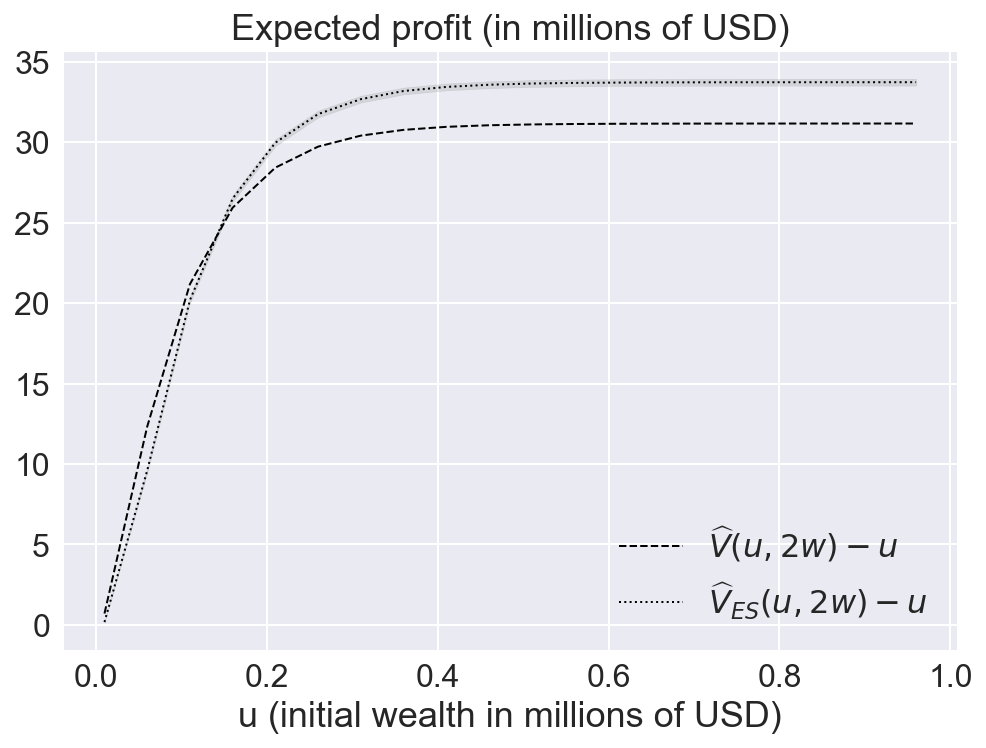

In [5]:
p, t = p_seq[2], t_seq[0]
for p in p_seq:
    subset_AG_df = V_AG_df[(V_AG_df['t'] == t) & (V_AG_df['p'] == p)]
    subset_ES = ψ_V_MC_df[(ψ_V_MC_df['t'] == t) & (ψ_V_MC_df['p'] == p) & (ψ_V_MC_df['strategy'] == "ES") ]
    subset_AG_MC = ψ_V_MC_df[(ψ_V_MC_df['t'] == t) & (ψ_V_MC_df['p'] == p) & (ψ_V_MC_df['strategy'] == "AG") ]
    plt.clf()
    plt.plot(u_vec / 1e6 , (subset_AG_df.V_T - u_vec)/ 1e6, '-', label = '$\widehat{V}(u,2w) - u$', linestyle = 'dashed', color = 'k', linewidth=1)
    plt.plot(u_vec / 1e6, (subset_ES.V_u_T - u_vec)/ 1e6, linestyle = 'dotted', label = '$\widehat{V}_{ES}(u,2w) - u$', color = 'k', linewidth=1)
    plt.fill_between(u_vec/ 1e6, (subset_ES['V_u_T_low'].values -u_vec)/ 1e6, 
                     (subset_ES['V_u_T_up'].values -u_vec)/ 1e6, alpha=0.2, color = 'grey')
    #     plt.fill_between(u_vec/ 1e6, (subset_AG_MC['V_u_T_low'].values -u_vec)/ 1e6, 
    #                      (subset_AG_MC['V_u_T_up'].values -u_vec)/ 1e6, alpha=0.2, color = 'grey')
    plt.xlabel('u (initial wealth in millions of USD)', fontsize = fontsize_axes)
    plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
    plt.tick_params(labelsize=fontsize_ticker)
    plt.legend(fontsize=fontsize_ticker)
    plt.savefig("../Figures/comparison_V_ES"+str(np.int(p*100))+".pdf", bbox_inches='tight')

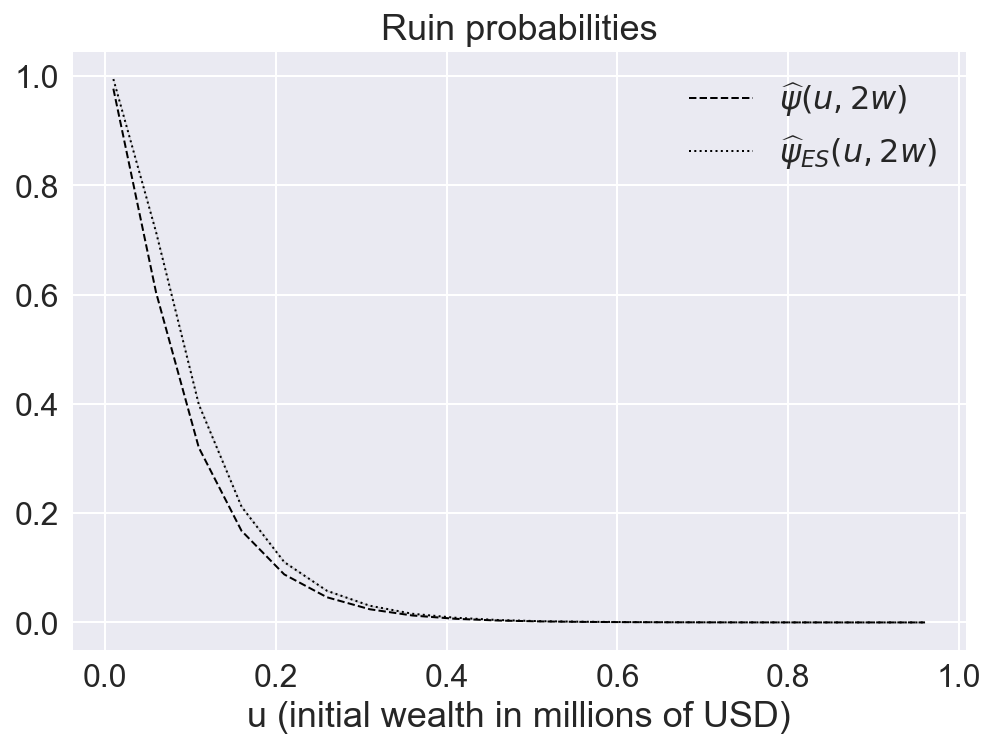

In [6]:
p, t = p_seq[2], t_seq[0]
for p in p_seq:
    
    subset_AG_df = rp_AG_df[(V_AG_df['t'] == t) & (rp_AG_df['p'] == p)]
    subset_ES = ψ_V_MC_df[(ψ_V_MC_df['t'] == t) & (ψ_V_MC_df['p'] == p) & (ψ_V_MC_df['strategy'] == "ES") ]
    subset_AG_MC = ψ_V_MC_df[(ψ_V_MC_df['t'] == t) & (ψ_V_MC_df['p'] == p) & (ψ_V_MC_df['strategy'] == "AG") ]
    plt.clf()
    plt.plot(u_vec / 1e6 , subset_AG_df.ψ_T, '-', label = '$\widehat{\psi}(u,2w)$', linestyle = 'dashed', color = 'k', linewidth=1)
    plt.plot(u_vec / 1e6, subset_ES.ψ_u_T, linestyle = 'dotted', label = '$\widehat{\psi}_{ES}(u,2w)$', color = 'k', linewidth=1)
    plt.fill_between(u_vec/ 1e6, subset_ES['ψ_u_T_up'].values, 
    subset_ES['ψ_u_T_low'].values, alpha=0.2, color = 'grey')
    #     plt.fill_between(u_vec/ 1e6, subset_AG_MC['ψ_u_T_up'].values, 
    #     subset_AG_MC['ψ_u_T_low'].values, alpha=0.2, color = 'grey')
    plt.xlabel('u (initial wealth in millions of USD)', fontsize = fontsize_axes)
    plt.title('Ruin probabilities', fontsize = fontsize_axes)
    plt.tick_params(labelsize=fontsize_ticker)
    plt.legend(fontsize=fontsize_ticker)
    plt.savefig("../Figures/comparison_rp_ES"+str(np.int(p*100))+".pdf", bbox_inches='tight')